## import libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
import seaborn as sns
from urllib.request import urlopen
import random


plt.style.use('ggplot')

## Read Data

In [3]:
data = pd.read_csv('C:/Users/pipatra.NSN-INTRA/Desktop/Anaconda/Projects/21-Sept/Rapido(Like_uber)/data/ML_Data_Rapido.csv')

In [4]:
data.head()

,is_weekend,is_weekday,is_start_of_week,is_end_of_week,is_weednesday,is_holiday,booking_class
0,True,False,False,False,False,False,1
1,False,True,True,False,False,False,1
2,False,True,True,False,False,False,1
3,False,True,False,False,True,False,1
4,False,True,False,True,False,False,1


In [5]:
def preprocessor(df):
    res_df = data.copy()
    le = preprocessing.LabelEncoder()
    
    res_df['is_weekend'] = le.fit_transform(res_df['is_weekend'])
    res_df['is_weekday'] = le.fit_transform(res_df['is_weekday'])
    res_df['is_start_of_week'] = le.fit_transform(res_df['is_start_of_week'])
    res_df['is_end_of_week'] = le.fit_transform(res_df['is_end_of_week'])
    res_df['is_weednesday'] = le.fit_transform(res_df['is_weednesday'])
    res_df['is_holiday'] = le.fit_transform(res_df['is_holiday'])
    return res_df

In [6]:
encoded_data = preprocessor(data)
encoded_data.head(2)

,is_weekend,is_weekday,is_start_of_week,is_end_of_week,is_weednesday,is_holiday,booking_class
0,1,0,0,0,0,0,1
1,0,1,1,0,0,0,1


## Create Data Frame as train and test data sets

In [8]:
attrition_space = encoded_data.drop('booking_class',axis=1).values
attrition_class = encoded_data['booking_class'].values

## Split Data in Train Test Split data sets

In [9]:
x_train,x_test,y_train,y_test = train_test_split(attrition_space,attrition_class,test_size=0.2)

## Random Forest Classifier

In [10]:
rf_fit = RandomForestClassifier(random_state=42)

## Build Random Forest model withg GridSearchCV

In [12]:
import time
np.random.seed(42)
start = time.time()

param_dist = {'max_depth':range(1,30,1),
             'bootstrap':[True,False],
             'max_features':['auto','sqrt','log2',None],
             'criterion':['gini','entropy']}

cv_rf = GridSearchCV(rf_fit,cv=10,param_grid=param_dist,n_jobs=3)

cv_rf.fit(x_train,y_train)
print('Best Parameters using Grid search: \n',cv_rf.best_params_)
end = time.time()
print('Time taken in grid search: %0.2f'%(end-start))

Best Parameters using Grid search: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'auto'}
Time taken in grid search: 45.34


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [13]:
rf_fit.set_params(bootstrap= True, criterion= 'gini', max_depth= 1, max_features= 'auto')

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

## OOB Error Rate

In [14]:
rf_fit.set_params(warm_start=True, 
                  oob_score=True)

min_estimators = 15
max_estimators = 1000

error_rate = {}

for i in range(min_estimators, max_estimators + 1):
    rf_fit.set_params(n_estimators=i)
    rf_fit.fit(x_train, y_train)

    oob_error = 1 - rf_fit.oob_score_
    error_rate[i] = oob_error

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [15]:
oob_series = pd.Series(error_rate)

Text(0.5, 1.0, 'OOB Error Rate Across various Forest sizes \n(From 15 to 1000 Trees)')

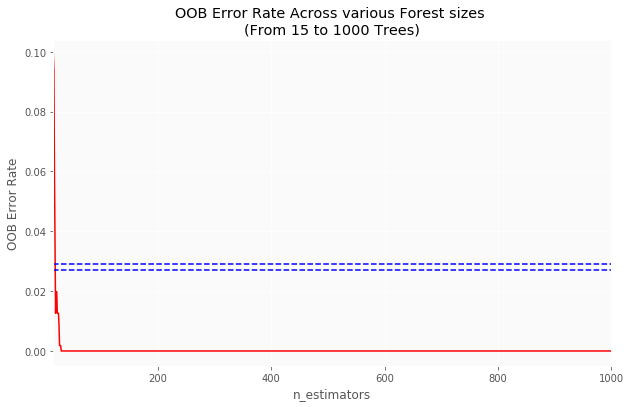

In [16]:
fig, ax = plt.subplots(figsize=(10,6))

ax.set_facecolor('#fafafa')

oob_series.plot(kind='line',color = 'red')
plt.axhline(0.027,color='blue',linestyle='--')
plt.axhline(0.029,color='blue',linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 15 to 1000 Trees)')

In [27]:
print('OOB Error rate for 25 trees is: %0.5f'%oob_series[25])

OOB Error rate for 25 trees is: 0.00901


In [29]:
rf_fit.set_params(n_estimators=25,bootstrap=True,warm_start=False,oob_score=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

## Train RF Model

In [30]:
rf_fit.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

## Performence Martrix

In [31]:
predictions_prob = rf_fit.predict_proba(x_test)[:, 1]

In [32]:
fpr_dt,tpr_dt,_=roc_curve(y_test,predictions_prob,pos_label=1)
roc_auc_dt = auc(fpr_dt,tpr_dt)

In [33]:
predictions = rf_fit.predict(x_test)
print(predictions)

print(rf_fit.score(x_test,y_test))

[0 0 1 0 1 1 1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0
 0 1 0 0 0 1 0 1 0 1 0 1 1 1 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0
 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1
 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0]
1.0


## Recall Check

In [35]:
y_actual_result = y_test[0]
print(y_actual_result)

0


In [36]:
for i in range(len(predictions)):
    if (predictions[i]==1):
        y_actual_result = np.vstack((y_actual_result,y_test[i]))
#         print(y_actual_result)

In [37]:
y_actual_result = y_actual_result.flatten()
count = 0
for result in y_actual_result:
    if (result == 1):
        count +=1
print("true yes|predict true yes:")
print(count/float(len(y_actual_result)))

true yes|predict true yes:
0.9803921568627451


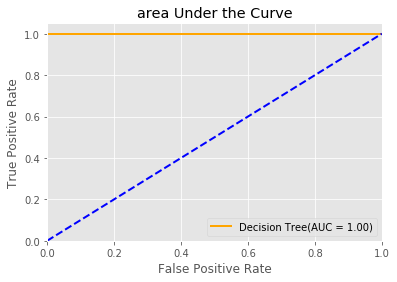

In [38]:
plt.figure(1)
lw=2
plt.plot(fpr_dt,tpr_dt,color='orange',lw=lw,label='Decision Tree(AUC = %0.2f)'%roc_auc_dt)
plt.plot([0,1],[0,1],color='blue',lw=lw,linestyle='--')

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("area Under the Curve")
# plt.legend(loc="upper left")
plt.legend(loc="lower right")

## Confution Matrix

In [39]:
print(confusion_matrix(y_test,predictions))

[[89  0]
 [ 0 50]]
